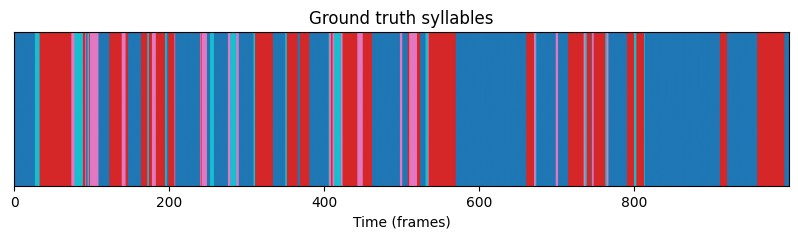

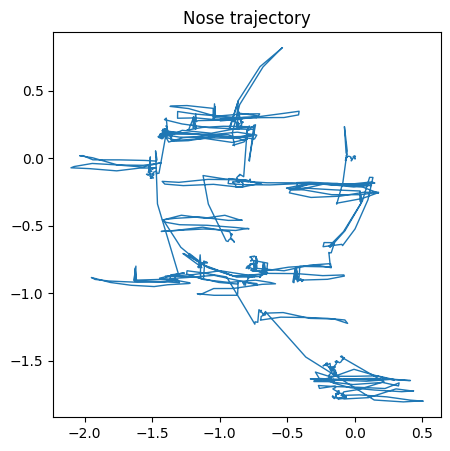

In [2]:
import numpy as np

def simulate_mouse(T=2000, n_parts=5, seed=0):
    rng = np.random.default_rng(seed)

    # Hidden states (4)
    K = 4
    A = np.array([[0.95, 0.03, 0.01, 0.01],
                  [0.05, 0.9,  0.03, 0.02],
                  [0.1,  0.1,  0.75, 0.05],
                  [0.1,  0.1,  0.1,  0.7]])
    z = np.zeros(T, dtype=int)
    for t in range(1, T):
        z[t] = rng.choice(K, p=A[z[t-1]])

    # Base skeleton layout (head → tail)
    base = np.array([
        [0.0, 0.0],  # nose
        [-1.0, 0.0], # neck
        [-2.0, 0.0], # spine
        [-3.0, 0.0], # tail_base
        [-4.0, 0.0], # tail_tip
    ])

    X = np.zeros((T, n_parts, 2))
    X[0] = base

    for t in range(1, T):
        X[t] = X[t-1].copy()
        s = z[t]

        if s == 0:  # idle
            X[t] += 0.01 * rng.normal(size=(n_parts, 2))

        elif s == 1:  # walk
            step = 0.2 * np.sin(2*np.pi*(t/10))
            X[t,:,0] += step  # forward motion
            X[t] += 0.02 * rng.normal(size=(n_parts, 2))

        elif s == 2:  # sniff
            X[t,0,1] += 0.1 * np.sin(2*np.pi*(t/3))  # nose oscillates
            X[t] += 0.01 * rng.normal(size=(n_parts, 2))

        elif s == 3:  # groom
            angle = 0.3 * np.sin(2*np.pi*(t/8))
            rot = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle),  np.cos(angle)]])
            X[t] = (X[t]-X[t,1]) @ rot.T + X[t,1]  # rotate around neck
            X[t] += 0.01 * rng.normal(size=(n_parts, 2))
    return X, z

import matplotlib.pyplot as plt

X, z = simulate_mouse(T=1000)
plt.figure(figsize=(10,2))
plt.imshow(z[None,:], aspect='auto', cmap='tab10')
plt.yticks([])
plt.xlabel('Time (frames)')
plt.title('Ground truth syllables')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(X[:,0,0], X[:,0,1], lw=1)
plt.title('Nose trajectory')
plt.axis('equal')
plt.show()


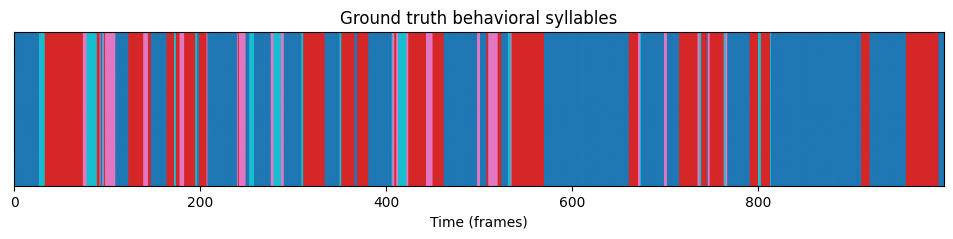

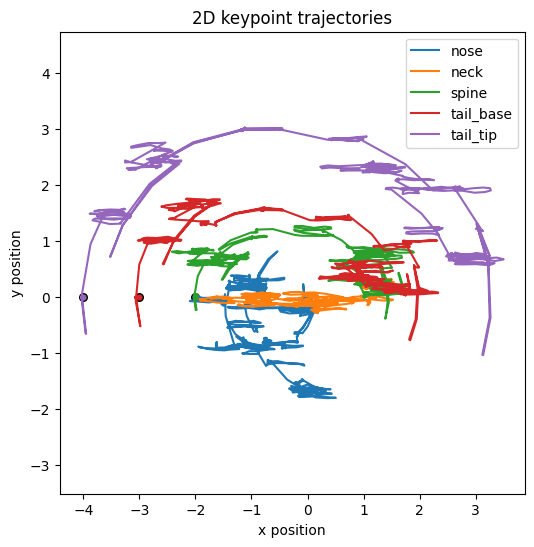

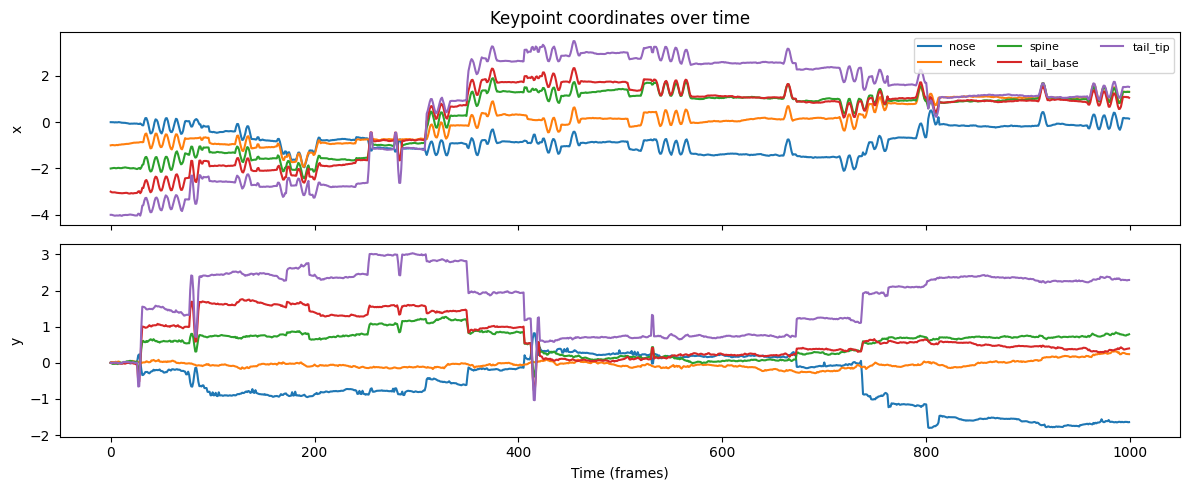

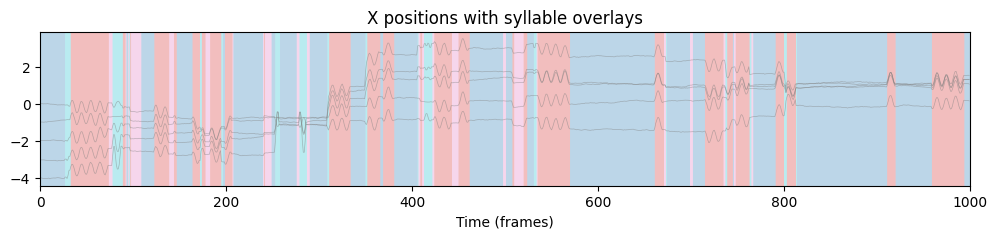

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simulation(X, z, keypoint_names=None):
    """
    Visualizes:
    1. Ground-truth syllables over time
    2. 2D trajectories for each keypoint
    3. X and Y coordinate traces vs. time
    """
    T, B, _ = X.shape
    if keypoint_names is None:
        keypoint_names = [f"part_{i}" for i in range(B)]

    # --- 1. Plot ground-truth syllables ---
    plt.figure(figsize=(12, 2))
    plt.imshow(z[None, :], aspect='auto', cmap='tab10')
    plt.yticks([])
    plt.xlabel("Time (frames)")
    plt.title("Ground truth behavioral syllables")
    plt.show()

    # --- 2. 2D trajectories of each keypoint ---
    plt.figure(figsize=(6, 6))
    for b in range(B):
        plt.plot(X[:, b, 0], X[:, b, 1], lw=1.5, label=keypoint_names[b])
        plt.scatter(X[0, b, 0], X[0, b, 1], s=30, marker='o', edgecolor='k')  # start
    plt.legend()
    plt.title("2D keypoint trajectories")
    plt.axis("equal")
    plt.xlabel("x position")
    plt.ylabel("y position")
    plt.show()

    # --- 3. X/Y positions over time ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    for b in range(B):
        axes[0].plot(X[:, b, 0], label=keypoint_names[b])
        axes[1].plot(X[:, b, 1], label=keypoint_names[b])
    axes[0].set_ylabel("x")
    axes[1].set_ylabel("y")
    axes[1].set_xlabel("Time (frames)")
    axes[0].set_title("Keypoint coordinates over time")
    axes[0].legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    plt.show()

    # --- 4. Optional: overlay syllables as colored background ---
    colors = plt.cm.tab10(z / z.max())
    fig, ax = plt.subplots(figsize=(12, 2))
    for b in range(B):
        ax.plot(X[:, b, 0], lw=0.5, color="gray", alpha=0.5)
    ax.imshow(z[None, :], aspect="auto", cmap="tab10", alpha=0.3, extent=[0, T, ax.get_ylim()[0], ax.get_ylim()[1]])
    ax.set_title("X positions with syllable overlays")
    ax.set_xlabel("Time (frames)")
    plt.show()

X, z = simulate_mouse(T=1000)
keypoint_names = ["nose", "neck", "spine", "tail_base", "tail_tip"]
plot_simulation(X, z, keypoint_names)


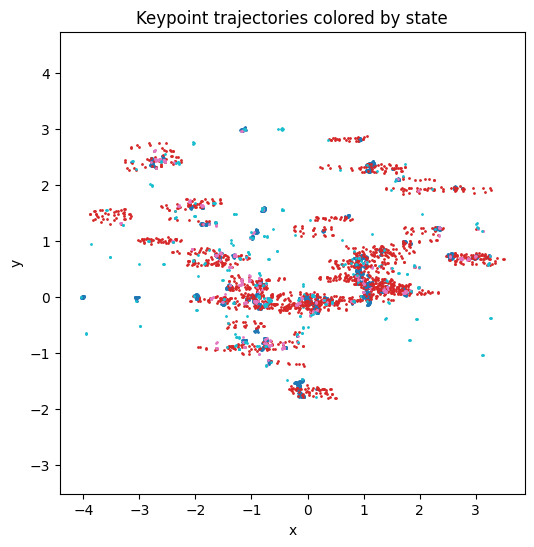

In [5]:
import matplotlib.pyplot as plt

def plot_by_state(X, z, keypoint_names):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.tab10
    for b, name in enumerate(keypoint_names):
        for s in np.unique(z):
            mask = z == s
            plt.plot(X[mask, b, 0], X[mask, b, 1], '.', ms=2,
                     color=cmap(s / max(z)), label=None)
        plt.plot([], [], color='k', label=name)  # dummy legend entry
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Keypoint trajectories colored by state')
    plt.show()

plot_by_state(X, z, keypoint_names)